In [2]:
#pip install matplotlib

     ---------------------------------------- 0.0/157.7 kB ? eta -:--:--
     ------- -------------------------------- 30.7/157.7 kB ? eta -:--:--
     ------------------- ----------------- 81.9/157.7 kB 919.0 kB/s eta 0:00:01
     ----------------------------- -------- 122.9/157.7 kB 1.0 MB/s eta 0:00:01
     ------------------------------------ 157.7/157.7 kB 945.6 kB/s eta 0:00:00
  Using cached Pillow-10.1.0-cp38-cp38-win_amd64.whl.metadata (9.6 kB)
   ---------------------------------------- 0.0/7.5 MB ? eta -:--:--
   ---------------------------------------- 0.1/7.5 MB 2.3 MB/s eta 0:00:04
    --------------------------------------- 0.2/7.5 MB 2.1 MB/s eta 0:00:04
   - -------------------------------------- 0.3/7.5 MB 1.8 MB/s eta 0:00:04
   -- ------------------------------------- 0.4/7.5 MB 2.1 MB/s eta 0:00:04
   -- ------------------------------------- 0.5/7.5 MB 2.1 MB/s eta 0:00:04
   --- ------------------------------------ 0.6/7.5 MB 2.0 MB/s eta 0:00:04
   --- ----------

In [2]:
#pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [5]:
def display_image(title, image):
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()

In [6]:
def filter_lines(lines, slope_threshold):
    left_lines = []
    right_lines = []

    for line in lines:
        x1, y1, x2, y2 = line[0]
        slope = (y2 - y1) / (x2 - x1 + 1e-10)  # Avoid division by zero

        if abs(slope) > slope_threshold:
            if slope < 0:  # Left lane
                left_lines.append(line)
            else:  # Right lane
                right_lines.append(line)

    return left_lines, right_lines

In [7]:
def draw_lines(image, left_lines, right_lines, color=(0, 255, 0), thickness=10, alpha=0.3):
    # Draw the left lane lines
    if len(left_lines) > 0:
        left_avg_slope = np.mean([((y2 - y1) / (x2 - x1 + 1e-10)) for line in left_lines for x1, y1, x2, y2 in line])
        left_avg_intercept = np.mean([y1 - left_avg_slope * x1 for line in left_lines for x1, y1, x2, y2 in line])
        y1 = int(image.shape[0])
        y2 = int(image.shape[0] * 0.6)
        left_x1 = int((y1 - left_avg_intercept) / left_avg_slope)
        left_x2 = int((y2 - left_avg_intercept) / left_avg_slope)
        cv2.line(image, (left_x1, y1), (left_x2, y2), color, thickness)

    # Draw the right lane lines
    if len(right_lines) > 0:
        right_avg_slope = np.mean([((y2 - y1) / (x2 - x1 + 1e-10)) for line in right_lines for x1, y1, x2, y2 in line])
        right_avg_intercept = np.mean([y1 - right_avg_slope * x1 for line in right_lines for x1, y1, x2, y2 in line])
        y1 = int(image.shape[0])
        y2 = int(image.shape[0] * 0.6)
        right_x1 = int((y1 - right_avg_intercept) / right_avg_slope)
        right_x2 = int((y2 - right_avg_intercept) / right_avg_slope)
        cv2.line(image, (right_x1, y1), (right_x2, y2), color, thickness)

    # Draw the green plane
    if alpha > 0:
        # If both lines are detected, create a mask for the green transparent plane
        if len(left_lines) > 0 and len(right_lines) > 0:
            mask = np.zeros_like(image)
            vertices = np.array([[(left_x1, y1), (left_x2, y2), (right_x2, y2), (right_x1, y1)]], dtype=np.int32)
            cv2.fillPoly(mask, vertices, color)

            # Combine the mask with the original image
            cv2.addWeighted(image, 1.0 - alpha, mask, alpha, 0, image)



In [8]:
def addWeighted(frame, line_image):
    return cv2.addWeighted(frame, 0.5, line_image, 0.5, 0.5)

In [13]:
def color_to_gray(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    display_image('Gray Scale Image', gray)
    return gray

In [33]:
def gray_to_blurred(gray):
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    display_image('Blurred Image', blurred)
    return blurred

In [17]:
def blurred_to_edge(blurred):
    edge = cv2.Canny(blurred, 50, 180)
    display_image('Edges', edge)
    return edge

In [18]:
def masked_edges_(edges, mask):
    masked_edges = cv2.bitwise_and(edges, mask)
    display_image('Masked Edges', masked_edges)
    return masked_edges

In [23]:
def detect_lanes_image(image):
    # Convert image to grayscale
    display_image('Original Frame', image)
    gray = color_to_gray(image)

    # Apply Gaussian blur
    blurred = gray_to_blurred(gray)
    
    # Apply Canny edge detection
    edges = blurred_to_edge(blurred)
    # Apply adaptive thresholding
    adaptive_thresh = cv2.adaptiveThreshold(
        edges, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2
    )

    # Define region of interest
    mask = np.zeros_like(adaptive_thresh)

    roi_vertices = np.array([(3, 715), (456, 378), (822, 374), (1231, 717)], dtype=np.int32)
    #roi_vertices = np.array([(252, 694), (607, 477), (751, 470), (1128, 689)], dtype = np.int32)
    #roi_vertices = np.array([(194, 681), (454, 522), (771, 508), (1142, 671)], dtype=np.int32)

    cv2.fillPoly(mask, [roi_vertices], 255)
    masked_edges = masked_edges_(edges, mask)
    # Apply Hough Transform to detect lines
    lines = cv2.HoughLinesP(masked_edges, 1, np.pi / 180, 50, minLineLength=100, maxLineGap=50)

    # Check if lines is not None
    if lines is not None:
        # Filter lines based on slope
        left_lines, right_lines = filter_lines(lines, slope_threshold=0.5)

        # Draw the left and right lane lines with the green transparent plane
        draw_lines(image, left_lines, right_lines, alpha=0.3)
        combo_img = addWeighted(frame, image)
    else:
        # If no lines are detected, return the original image
        combo_img = np.copy(image)

    return combo_img


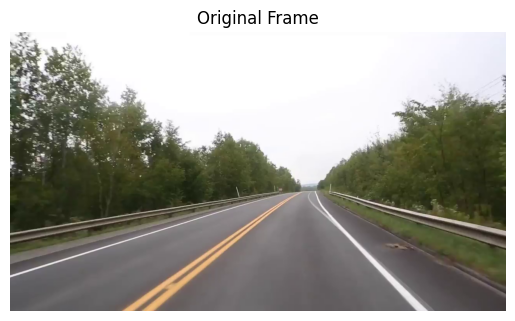

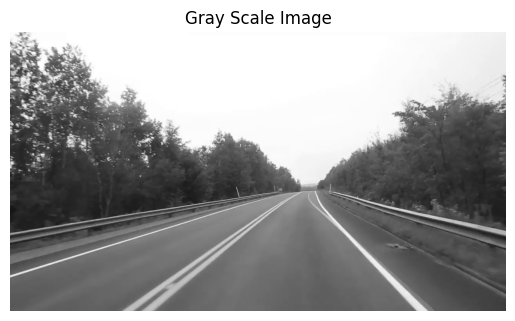

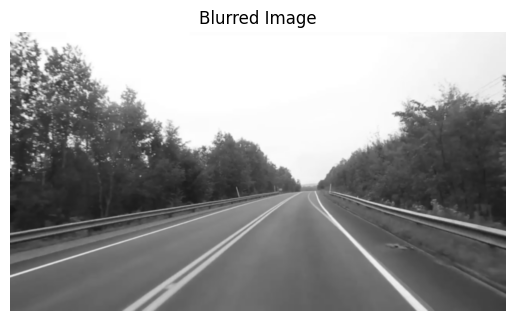

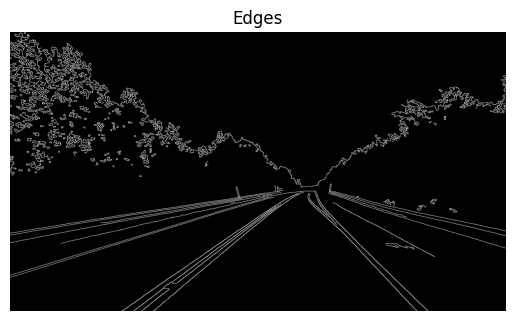

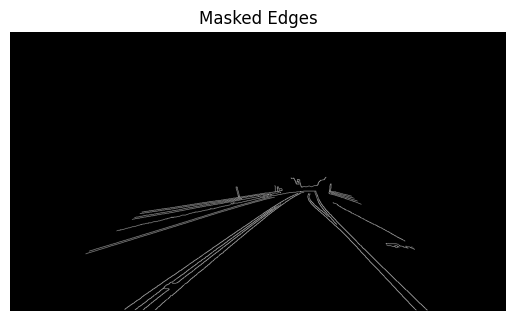

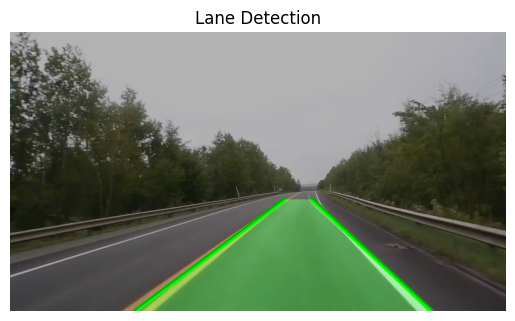

In [34]:
#image
import cv2

cap = cv2.VideoCapture('Lane2.mp4')

# Read a single frame from the video
ret, frame = cap.read()

# Check if the frame is read successfully
if not ret:
    print("Error: Could not read frame.")
    exit()

# Detect lanes in the processed frame
detected_lanes = detect_lanes_image(frame)

# Display the original and processed frames

display_image('Lane Detection', detected_lanes)

# Wait for a key press and close windows
cv2.waitKey(0)
cv2.destroyAllWindows()

# Release the video capture object
cap.release()


In [10]:
def detect_lanes(image):
    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    # Apply Canny edge detection
    edges = cv2.Canny(blurred, 50, 180)
    # Apply adaptive thresholding
    adaptive_thresh = cv2.adaptiveThreshold(
        edges, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2
    )

    # Define region of interest
    mask = np.zeros_like(adaptive_thresh)

    roi_vertices = np.array([(3, 715), (456, 378), (822, 374), (1231, 717)], dtype=np.int32)

    cv2.fillPoly(mask, [roi_vertices], 255)
    masked_edges = cv2.bitwise_and(edges, mask)
    # Apply Hough Transform to detect lines
    lines = cv2.HoughLinesP(masked_edges, 1, np.pi / 180, 50, minLineLength=100, maxLineGap=50)

    # Check if lines is not None
    if lines is not None:
        # Filter lines based on slope
        left_lines, right_lines = filter_lines(lines, slope_threshold=0.5)

        # Draw the left and right lane lines with the green transparent plane
        draw_lines(image, left_lines, right_lines, alpha=0.3)
        combo_img = addWeighted(frame, image)
    else:
        # If no lines are detected, return the original image
        combo_img = np.copy(image)

    return combo_img


In [22]:
#video
import cv2

cap = cv2.VideoCapture('Lane detect test data.mp4')
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('output_video.avi', fourcc, 20.0, (int(cap.get(3)), int(cap.get(4))))

while (cap.isOpened()):
    ret, frame = cap.read()
    if not ret:
        break

    #edges = process_frame(frame)
    # Detect lanes
    detected_lanes = detect_lanes(frame)

    # Display the output
    cv2.imshow('Lane Detection', detected_lanes)
    #cv2.imshow('Edge Detection', edges)
    # Write the frame to the output video
    out.write(detected_lanes)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the video capture and writer objects
cap.release()
out.release()
cv2.destroyAllWindows()

